In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from baseline.main_model import *

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
pd.options.display.max_rows = 50
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.4f}'.format

In [4]:
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
intraday_file = 'fandi_intraday_data.csv'
daily_file = 'fandi_daily.csv'
ticker = 'GOOGL'
date = '2021-12-02'

In [6]:
df = pd.read_csv(intraday_file)

In [7]:
df = df.groupby('sym_root').get_group('GOOG') # just to make sure i save the original one without changing the time format
df_sample = df.groupby('sym_root').get_group('GOOG')

In [8]:
df['time']  = pd.to_timedelta(df['time'])
df['date'] = pd.to_datetime(df['date'])# format='%Y%m%d')

In [9]:
df = df[df['date'] == '2021-12-02']
df_sample = df_sample[df_sample['date'] == '2021-12-02']
df_sample['datetime'] = df['date'] + df['time']
df_sample = df_sample.set_index('datetime')

In [10]:
df_sample = df_sample[df_sample['sym_suffix'] == 'L']

In [11]:
df_sample['time'] = pd.to_datetime(df_sample['time']).dt.strftime('%H:%M:%S')

In [12]:
df_sample = df_sample.between_time('9:40:00','15:59:00')

In [13]:
df_sample

,date,time,sym_root,sym_suffix,size
datetime,,,,,
2021-12-02 09:40:00,2021-12-02,09:40:00,GOOG,L,7334.0000
2021-12-02 09:41:00,2021-12-02,09:41:00,GOOG,L,12669.0000
2021-12-02 09:42:00,2021-12-02,09:42:00,GOOG,L,3798.0000
2021-12-02 09:43:00,2021-12-02,09:43:00,GOOG,L,3486.0000
2021-12-02 09:44:00,2021-12-02,09:44:00,GOOG,L,4401.0000
...,...,...,...,...,...
2021-12-02 15:55:00,2021-12-02,15:55:00,GOOG,L,11992.0000
2021-12-02 15:56:00,2021-12-02,15:56:00,GOOG,L,14068.0000
2021-12-02 15:57:00,2021-12-02,15:57:00,GOOG,L,15344.0000


In [14]:
prediction = main(intraday_file, daily_file, ticker, date)

In [15]:
prediction['daily']

{'Daily': 1394462, 'Open_Auction': 19932, 'Close_Auction': 120916}

In [16]:
result = prediction['intraday']
result = result[9:]

In [17]:
result

09:40:00    5936.0000
09:41:00    5827.0000
09:42:00    5568.0000
09:43:00    5436.0000
09:44:00    5342.0000
              ...    
15:55:00   13221.0000
15:56:00   14578.0000
15:57:00   18007.0000
15:58:00   16920.0000
15:59:00   33786.0000
Name: est_vol, Length: 380, dtype: float64

In [18]:
#vix = pd.read_csv('vix_prices.csv')

In [19]:
google = pd.read_csv('google_price.csv')

### Data Preprocessing

In [20]:
google['TIME_M']  = google['TIME_M'].apply(lambda x: '0'+x[:4]+':00' if x[1]==':' else x[:5]+':00')
google['TIME_M']  = pd.to_timedelta(google['TIME_M'])
google['DATE'] = pd.to_datetime(google['DATE'], format='%Y%m%d')
google['datetime'] = google['DATE'] + google['TIME_M']

In [21]:
google = google[google['SYM_SUFFIX'] =='L']

In [22]:
GOOG = google.groupby('datetime').last()


In [23]:
GOOG = GOOG[GOOG['DATE'] == '2021-12-02']
GOOG

,DATE,TIME_M,SYM_ROOT,SYM_SUFFIX,PRICE
datetime,,,,,
2021-12-02 04:00:00,2021-12-02,0 days 04:00:00,GOOG,L,2842.0800
2021-12-02 04:01:00,2021-12-02,0 days 04:01:00,GOOG,L,2840.4900
2021-12-02 04:02:00,2021-12-02,0 days 04:02:00,GOOG,L,2842.0000
2021-12-02 04:03:00,2021-12-02,0 days 04:03:00,GOOG,L,2843.0000
2021-12-02 04:04:00,2021-12-02,0 days 04:04:00,GOOG,L,2846.0000
...,...,...,...,...,...
2021-12-02 19:53:00,2021-12-02,0 days 19:53:00,GOOG,L,2848.0000
2021-12-02 19:55:00,2021-12-02,0 days 19:55:00,GOOG,L,2848.0000
2021-12-02 19:57:00,2021-12-02,0 days 19:57:00,GOOG,L,2848.1000


In [24]:
GOOG['%_pr'] = GOOG['PRICE'].pct_change().round(decimals = 4) + 1

In [25]:
GOOG

,DATE,TIME_M,SYM_ROOT,SYM_SUFFIX,PRICE,%_pr
datetime,,,,,,
2021-12-02 04:00:00,2021-12-02,0 days 04:00:00,GOOG,L,2842.0800,NaN
2021-12-02 04:01:00,2021-12-02,0 days 04:01:00,GOOG,L,2840.4900,0.9994
2021-12-02 04:02:00,2021-12-02,0 days 04:02:00,GOOG,L,2842.0000,1.0005
2021-12-02 04:03:00,2021-12-02,0 days 04:03:00,GOOG,L,2843.0000,1.0004
2021-12-02 04:04:00,2021-12-02,0 days 04:04:00,GOOG,L,2846.0000,1.0011
...,...,...,...,...,...,...
2021-12-02 19:53:00,2021-12-02,0 days 19:53:00,GOOG,L,2848.0000,1.0018
2021-12-02 19:55:00,2021-12-02,0 days 19:55:00,GOOG,L,2848.0000,1.0000
2021-12-02 19:57:00,2021-12-02,0 days 19:57:00,GOOG,L,2848.1000,1.0000


In [26]:
GOOG['pr_sd'] = GOOG['%_pr'].rolling(10).std()

In [27]:
GOOG = GOOG.between_time('9:40:00','15:59:00')
GOOG

,DATE,TIME_M,SYM_ROOT,SYM_SUFFIX,PRICE,%_pr,pr_sd
datetime,,,,,,,
2021-12-02 09:40:00,2021-12-02,0 days 09:40:00,GOOG,L,2836.5500,1.0002,0.0026
2021-12-02 09:41:00,2021-12-02,0 days 09:41:00,GOOG,L,2829.0600,0.9974,0.0025
2021-12-02 09:42:00,2021-12-02,0 days 09:42:00,GOOG,L,2833.6300,1.0016,0.0025
2021-12-02 09:43:00,2021-12-02,0 days 09:43:00,GOOG,L,2834.3200,1.0002,0.0015
2021-12-02 09:44:00,2021-12-02,0 days 09:44:00,GOOG,L,2831.3800,0.9990,0.0016
...,...,...,...,...,...,...,...
2021-12-02 15:55:00,2021-12-02,0 days 15:55:00,GOOG,L,2851.4150,0.9971,0.0010
2021-12-02 15:56:00,2021-12-02,0 days 15:56:00,GOOG,L,2855.3900,1.0014,0.0012
2021-12-02 15:57:00,2021-12-02,0 days 15:57:00,GOOG,L,2857.7250,1.0008,0.0013


In [28]:
res = df_sample['size'].values - result

In [29]:
GOOG['residual'] = res.values
GOOG

,DATE,TIME_M,SYM_ROOT,SYM_SUFFIX,PRICE,%_pr,pr_sd,residual
datetime,,,,,,,,
2021-12-02 09:40:00,2021-12-02,0 days 09:40:00,GOOG,L,2836.5500,1.0002,0.0026,1398.0000
2021-12-02 09:41:00,2021-12-02,0 days 09:41:00,GOOG,L,2829.0600,0.9974,0.0025,6842.0000
2021-12-02 09:42:00,2021-12-02,0 days 09:42:00,GOOG,L,2833.6300,1.0016,0.0025,-1770.0000
2021-12-02 09:43:00,2021-12-02,0 days 09:43:00,GOOG,L,2834.3200,1.0002,0.0015,-1950.0000
2021-12-02 09:44:00,2021-12-02,0 days 09:44:00,GOOG,L,2831.3800,0.9990,0.0016,-941.0000
...,...,...,...,...,...,...,...,...
2021-12-02 15:55:00,2021-12-02,0 days 15:55:00,GOOG,L,2851.4150,0.9971,0.0010,-1229.0000
2021-12-02 15:56:00,2021-12-02,0 days 15:56:00,GOOG,L,2855.3900,1.0014,0.0012,-510.0000
2021-12-02 15:57:00,2021-12-02,0 days 15:57:00,GOOG,L,2857.7250,1.0008,0.0013,-2663.0000


In [30]:
reg = smf.ols(formula = "residual ~ pr_sd",data = GOOG).fit()
GOOG['vol_est'] = result.values + reg.params[1] * GOOG['pr_sd'].values + reg.params[0]
GOOG

,DATE,TIME_M,SYM_ROOT,SYM_SUFFIX,PRICE,%_pr,pr_sd,residual,vol_est
datetime,,,,,,,,,
2021-12-02 09:40:00,2021-12-02,0 days 09:40:00,GOOG,L,2836.5500,1.0002,0.0026,1398.0000,6975.6986
2021-12-02 09:41:00,2021-12-02,0 days 09:41:00,GOOG,L,2829.0600,0.9974,0.0025,6842.0000,6844.2595
2021-12-02 09:42:00,2021-12-02,0 days 09:42:00,GOOG,L,2833.6300,1.0016,0.0025,-1770.0000,6537.2601
2021-12-02 09:43:00,2021-12-02,0 days 09:43:00,GOOG,L,2834.3200,1.0002,0.0015,-1950.0000,5600.3534
2021-12-02 09:44:00,2021-12-02,0 days 09:44:00,GOOG,L,2831.3800,0.9990,0.0016,-941.0000,5601.0930
...,...,...,...,...,...,...,...,...,...
2021-12-02 15:55:00,2021-12-02,0 days 15:55:00,GOOG,L,2851.4150,0.9971,0.0010,-1229.0000,13005.4672
2021-12-02 15:56:00,2021-12-02,0 days 15:56:00,GOOG,L,2855.3900,1.0014,0.0012,-510.0000,14502.2710
2021-12-02 15:57:00,2021-12-02,0 days 15:57:00,GOOG,L,2857.7250,1.0008,0.0013,-2663.0000,17992.4113


In [31]:
df_sample['size']

datetime
2021-12-02 09:40:00    7334.0000
2021-12-02 09:41:00   12669.0000
2021-12-02 09:42:00    3798.0000
2021-12-02 09:43:00    3486.0000
2021-12-02 09:44:00    4401.0000
                         ...    
2021-12-02 15:55:00   11992.0000
2021-12-02 15:56:00   14068.0000
2021-12-02 15:57:00   15344.0000
2021-12-02 15:58:00   16826.0000
2021-12-02 15:59:00   52509.0000
Name: size, Length: 380, dtype: float64

In [32]:
default_x_ticks = [df_sample.time.values[i]for i in range(0, df_sample.shape[0],10)]

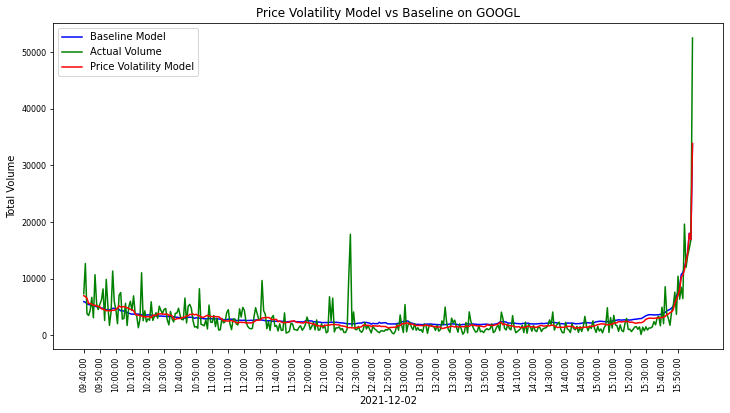

In [33]:
plt.plot(df_sample['time'].values,result.values,c = 'b', label = 'Baseline Model')
plt.plot(df_sample['time'].values, df_sample['size'], c = 'g', label = 'Actual Volume')
plt.plot(df_sample['time'].values, GOOG['vol_est'],c = 'r', label = 'Price Volatility Model')
plt.legend()
plt.title("Price Volatility Model vs Baseline on GOOGL")
plt.xticks(rotation=90)
plt.xlabel("2021-12-02")
plt.ylabel("Total Volume")
plt.xticks(default_x_ticks)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.show()

In [34]:
len(default_x_ticks)

38

In [35]:
set_ticks_two = default_x_ticks[9:20]

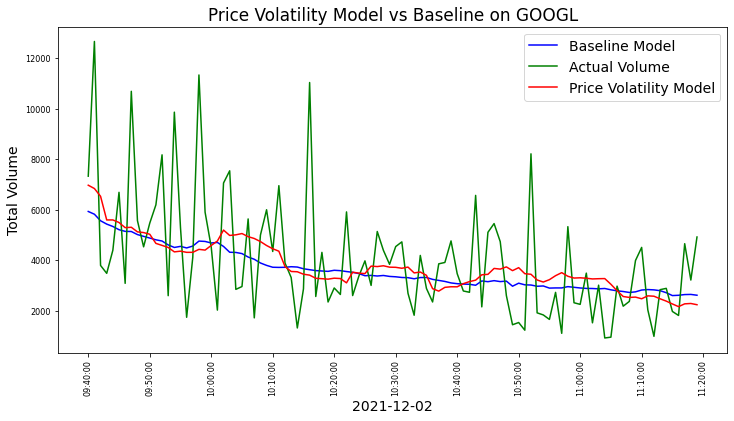

In [ ]:
plt.plot(df_sample['time'].values[:100],result.values[:100],c = 'b', label = 'Baseline Model')
plt.plot(df_sample['time'].values[:100],df_sample['size'][:100], c = 'g', label = 'Actual Volume')
plt.plot(df_sample['time'].values[:100], GOOG['vol_est'][:100],c = 'r', label = 'Price Volatility Model')
plt.legend()
plt.title("Price Volatility Model vs Baseline on GOOGL")
plt.xticks(rotation=90)
plt.xlabel("2021-12-02")
plt.ylabel("Total Volume")
plt.xticks(set_ticks)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.show()

In [ ]:
abs_val = np.abs(GOOG['vol_est'] - df_sample['size'])/ df_sample['size']

In [ ]:
np.sum(abs_val)/len(abs_val)

0.7917927347286982

In [ ]:
bas_val = np.abs(result.values - df_sample['size'])/ df_sample['size'] 
np.sum(bas_val)/len(bas_val)

1.0289581992296437

$$
\frac{1}{N(minute)}\sum_{t}\left\lvert{\frac{\hat{y_{t}} - y_{t}}{y_{t}}}\right\rvert
$$

<center>

|Company|Baseline Residual|Price in minute Effect Residual|
| :--: | :--: | :--: |
|GOOG|1.02895|0.79179|




In [ ]:
df_sample

,date,time,sym_root,sym_suffix,size
datetime,,,,,
2021-12-02 09:40:00,2021-12-02,09:40:00,GOOG,L,7334.0000
2021-12-02 09:41:00,2021-12-02,09:41:00,GOOG,L,12669.0000
2021-12-02 09:42:00,2021-12-02,09:42:00,GOOG,L,3798.0000
2021-12-02 09:43:00,2021-12-02,09:43:00,GOOG,L,3486.0000
2021-12-02 09:44:00,2021-12-02,09:44:00,GOOG,L,4401.0000
...,...,...,...,...,...
2021-12-02 15:55:00,2021-12-02,15:55:00,GOOG,L,11992.0000
2021-12-02 15:56:00,2021-12-02,15:56:00,GOOG,L,14068.0000
2021-12-02 15:57:00,2021-12-02,15:57:00,GOOG,L,15344.0000


In [ ]:
def scatter_gap_normalized(stock):
    plt.xlabel('Price Volatility')
    plt.ylabel('Residual Log Volume')
    plt.title("Price Volatility versus Residual Intraday Volume - GOOG")
    plt.scatter(stock.pr_sd,np.log(stock.vol_est) - np.log(df_sample['size'])) #np.log(df_sample['size']).rolling(20).mean())
    #plt.savefig('Normalized_' + ticker + '_PG_ETA.png', dpi=300)
    plt.show()

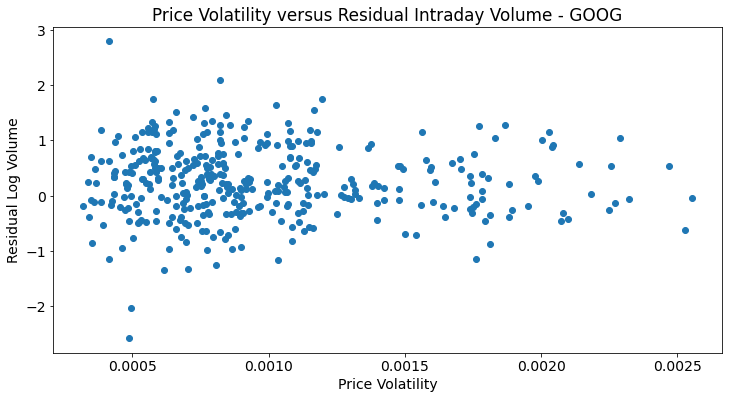

In [ ]:
scatter_gap_normalized(GOOG)